PINN解Burgers方程

初始条件：$u(0, x)=sin(\pi x)$

边界条件：$\begin{cases}
    u(t, -1)=0 \\
    u(t, 1)=0
    \end{cases}$


In [13]:
%reset -f

In [14]:
import torch
from utils import torchIWT
import numpy as np
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.autograd import Variable
from scipy.stats import gaussian_kde
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
seed = 2947
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [16]:
def get_possion_data(Nf, Nt):
    x_f = torch.linspace(-1, 1, Nf).unsqueeze(-1).to(device)
    x_test = torch.linspace(-1, 1, Nt).unsqueeze(-1).to(device)
    x_test_exact = 0.1 * torch.sin(4 * torch.pi * x_test) + torch.tanh(50 * x_test)
    x_test_exact = x_test_exact.to(device)
    x_label = torch.tensor([[-1], [1]]).float().to(device)
    x_labels = 0.1 * torch.sin(4 * torch.pi * x_label) + torch.tanh(50 * x_label)
    x_labels = x_labels.to(device)
    return x_f, x_test, x_test_exact, x_label, x_labels

In [17]:
class Net(nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        self.layers = layers
        self.activation = nn.Tanh()
        self.linear = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linear[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linear[i].bias.data)
    def forward(self, x):
        a = self.activation(self.linear[0](x))
        for i in range(1, len(self.layers) - 2):
            z = self.linear[i](a)
            a = self.activation(z)
        a = self.linear[-1](a)
        return a

In [18]:
class Model:
    def __init__(self, net, epoch,
                 lb, ub,
                 x_bc, u_bc,
                 x,
                 x_test_point, x_test_exact,
                 x_f_loss_fun,
                 ):
        self.net = net
        self.epoch = epoch
        self.lb = lb
        self.ub = ub

        self.x_bc = x_bc
        self.u_bc = u_bc

        self.x_f = x

        self.x_f_loss_fun = x_f_loss_fun
        self.x_test_point = x_test_point
        self.x_test_exact = x_test_exact

        self.sample_N = int(len(self.x_f) / 2)
        self.sample_M = len(self.x_f) - self.sample_N

        self.x_f_N = None
        self.x_f_M = None

        self.x_bc_s = torch.tensor(0.).float().to(device)
        self.x_f_s = torch.tensor(0.).float().to(device)

        self.x_test_estimate_collect = []

        self.top1 = torch.inf

    def true_loss(self, loss_e, loss_bc):
        loss = torch.exp(-self.x_f_s.detach()) * loss_e \
                + torch.exp(-self.x_bc_s.detach()) * loss_bc
        return loss
    
    def likelihood_loss(self, loss_e, loss_bc):
        loss = torch.exp(-self.x_f_s) * loss_e.detach() + self.x_f_s \
                + torch.exp(-self.x_bc_s) * loss_bc.detach() + self.x_bc_s
        return loss
    
    def evaluate(self):
        pred = self.net(self.x_test_point).cpu().detach().numpy()
        exact = self.x_test_exact.cpu().detach().numpy()
        error = np.linalg.norm(pred - exact, 2) / np.linalg.norm(exact, 2)
        return error
    

    def run(self, lr, wlr, j0, J_tmp, e_tmp):

        optim = torch.optim.Adam(self.net.parameters(), lr)
        optim_weight = torch.optim.Adam([self.x_f_s] + [self.x_bc_s], lr=wlr)
        optim2 = torch.optim.LBFGS(self.net.parameters(), lr=1.0,
            max_iter=50000, max_eval=50000, history_size=50,
            tolerance_grad=1e-7, tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
        )

        for i in range(self.epoch):
            u_bc_pred = self.net(self.x_bc)
            f_pred = self.x_f_loss_fun(self.x_f, self.net)

            # loss_e = torch.mean(f_pred ** 2) * 10
            # loss_bc = torch.mean((u_bc_pred - self.u_bc) ** 2) * 10

            loss_e = torch.mean(f_pred ** 2)
            loss_bc = torch.mean((u_bc_pred - self.u_bc) ** 2)
            optim.zero_grad()

            loss = self.true_loss(loss_e, loss_bc)  # metohd1
            # loss = loss_e + loss_bc
            
            loss.backward()
            optim.step()
            if (i % 2500) == 0 and (i != 0):
                self.move_point(j0, J_tmp, e_tmp)
            print('network train epoch: {}, loss: {}'.format(i, loss.item()), end='\r')
            
            optim_weight.zero_grad()
            loss = self.likelihood_loss(loss_e, loss_bc)
            loss.backward()
            optim_weight.step()
        print("\nOPTIM1 DONE")


        closure_i = 0
        def closure():
            optim2.zero_grad()
            u_bc_pred = self.net(self.x_bc)
            x_f = torch.cat((self.x_f_N, self.x_f_M), dim=0)
            f_pred = self.x_f_loss_fun(x_f, self.net)

            # loss_e = torch.mean(f_pred ** 2) * 10
            # loss_bc = torch.mean((u_bc_pred - self.u_bc) ** 2) * 10
            # loss = loss_e + loss_bc

            loss_e = torch.mean(f_pred ** 2)
            loss_bc = torch.mean((u_bc_pred - self.u_bc) ** 2)
            loss = self.true_loss(loss_e, loss_bc)

            loss.backward()
            nonlocal closure_i
            closure_i += 1
            # if closure_i % 2500 == 0:
            #     self.move_point(j0, J_tmp, e_tmp)
            print('network train epoch: {}, OPTIM2 LOSS:{}'.format(closure_i, loss.item()), end='\r')
            return loss
        
        optim2.step(closure)
        print("\nOPTIM2 DONE")
        error = self.evaluate()
        if error < self.top1:
            self.top1 = error
            torch.save(self.net.state_dict(), './best_model.pth')
        print('Test_L2error:', '{0:.2e}'.format(error))
        self.x_test_estimate_collect.append([error])
            
    def train(self, move_epoch, lr, wlr, j0, J, e):
        self.x_f_N = torch.linspace(-1, 1, self.sample_N).unsqueeze(-1).to(device)
        self.x_f_M = torch.linspace(-1, 1, self.sample_M).unsqueeze(-1).to(device)

        self.x_f_s = torch.tensor(0.).float().to(device)
        self.x_bc_s = torch.tensor(0.).float().to(device)

        self.x_f_s = nn.Parameter(self.x_f_s, requires_grad=True)
        self.x_bc_s = nn.Parameter(self.x_bc_s, requires_grad=True)
        
        self.run(lr[0], wlr, j0, J, e)

        for j in range(1, move_epoch):
            print("epoch: ", j)
            if j > 4:
                lr_tmp = lr[-1]
            else:
                lr_tmp = lr[j]
            self.run(lr_tmp, wlr, j0, J, e) 
    
    def move_point(self, j0, J_tmp, e_tmp):
        imgl = self.net(self.x_test_point).reshape(self.x_test_point.shape[0], 1)
        iwt = torchIWT(j0, J_tmp, e_tmp).to(device)
        _, idxs = iwt.get_Iwt2d(imgl, self.x_test_point, torch.tensor([[1.0]]).to(device))
        idxn = []
        for i in idxs:
            idxn = idxn + i
        idxn = torch.tensor(idxn).float()[:,0].reshape(-1,1)
        # 去除idxn中的重复点
        idxn = torch.unique(idxn, dim=0)
        kde = gaussian_kde(idxn[:,0].cpu())
        expanded_idxns = kde.resample(self.sample_M).reshape(-1, 1)
        expanded_idxns = torch.tensor(expanded_idxns).float()

        k = torch.cat((idxn, expanded_idxns), dim=0)
        k = 2 * k / self.x_test_point.shape[0] - 1. # x
        k = k[(k >= self.lb) & (k <= self.ub)]
    
        self.x_f_M = k.reshape(-1, 1).to(device)
        self.x_f = torch.cat((self.x_f_N, self.x_f_M), dim=0)
        # x_f排序，并剔除重复点
        self.x_f, _ = torch.sort(self.x_f, dim=0)
        self.x_f = torch.unique(self.x_f, dim=0)
        
        
        print("\nnumber of moved point:{}".format(self.x_f_M.shape[0]))

In [19]:
def x_f_loss_fun(x, train_U):
    if not x.requires_grad:
        x = Variable(x, requires_grad=True)
    u = train_U(x)
    dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    dxx = torch.autograd.grad(dx, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    f = dxx + 50 * (100 - 100 * torch.tanh(50 * x) ** 2) * torch.tanh(50 * x) + \
        1.6 * torch.pi ** 2 * torch.sin(4 * torch.pi * x)
    return f

In [20]:
Nf = 400
Nt = 10000
x, x_test_point, x_test_exact, x_bc, u_bc = get_possion_data(Nf, Nt)

In [21]:
layers = [1, 20, 20, 20, 20, 1]
net = Net(layers)
net = net.to(device)

lb = torch.tensor([-1.]).float()
ub = torch.tensor([1.]).float()

epoch = 5000

model = Model(net, epoch, 
              lb, ub, 
              x_bc, u_bc,
              x, 
              x_test_point, x_test_exact, x_f_loss_fun)


# lr = [0.001, 0.001, 0.0003, 0.0001, 0.00003]
lr = [0.001, 0.001, 0.001, 0.001, 0.001]
wlr = 0.001

j0 = 0
J = 5
e = 0.003

In [22]:
model.train(move_epoch=10, lr=lr, wlr=wlr, j0=j0, J=J, e=e)  # 10

network train epoch: 2499, loss: 77.673202514648447
number of moved point:220
network train epoch: 4999, loss: 52.345817565917974
OPTIM1 DONE
network train epoch: 9, OPTIM2 LOSS:52.219192504882814
OPTIM2 DONE
Test_L2error: 4.34e-01
epoch:  1
network train epoch: 2499, loss: 9.1576404571533281
number of moved point:230
network train epoch: 4999, loss: 0.25606572628021245
OPTIM1 DONE
network train epoch: 10, OPTIM2 LOSS:0.25962772965431213
OPTIM2 DONE
Test_L2error: 3.22e-02
epoch:  2
network train epoch: 2499, loss: 0.039528679102659225
number of moved point:231
network train epoch: 4999, loss: 0.036336600780487065
OPTIM1 DONE
network train epoch: 91, OPTIM2 LOSS:0.030787648633122444
OPTIM2 DONE
Test_L2error: 3.68e-03
epoch:  3
network train epoch: 2499, loss: 0.134561046957969675
number of moved point:235
network train epoch: 4999, loss: 0.574645400047302265
OPTIM1 DONE
network train epoch: 423, OPTIM2 LOSS:0.024556115269660953
OPTIM2 DONE
Test_L2error: 3.92e-03
epoch:  4
network train 

In [23]:
x_test_pred = net(x_test_point)

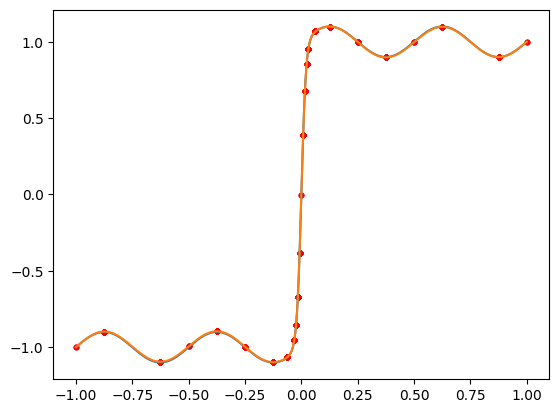

In [24]:
plt.plot(x_test_point.detach().cpu().numpy(), x_test_exact.detach().cpu().numpy(), label='PINN')
plt.plot(x_test_point.detach().cpu().numpy(), x_test_pred.detach().cpu().numpy(), label='True')

iwt = torchIWT(j0, 7, 0.03).to(device)
_, idxs = iwt.get_Iwt2d(x_test_pred, model.x_test_point, torch.tensor([[1.0]]).to(device))
idxn = []
for i in idxs:
    idxn = idxn + i
idxn = torch.tensor(idxn).to(device).float()
# 突出显示的点
plt.scatter(model.x_test_point[idxn[:,0].long()].detach().cpu().numpy(), x_test_pred[idxn[:,0].long()].detach().cpu().numpy(), c='r', s=10, label='IWT')